<a href="https://colab.research.google.com/github/JamesPeralta/NeuroNexus2019/blob/master/ModelTraining/Final_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount drive and download libraries from Github

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Any imports

In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import cv2 
from sklearn.feature_extraction import image
import math
from keras.utils import np_utils
import keras
from sklearn.utils import shuffle
from skimage import io, color, img_as_float
from skimage.exposure import adjust_gamma

### Retrieve slices and thier ground-truth

In [203]:
# CD into the data
# CD into the data
t1 = '/content/drive/My Drive/#6_Brain_Segmentation/Scans/HC/HC_T1.nii'
c1 = '/content/drive/My Drive/#6_Brain_Segmentation/Scans/HC/c1HC_T1.nii'
c2 = '/content/drive/My Drive/#6_Brain_Segmentation/Scans/HC/c2HC_T1.nii'
c3 = '/content/drive/My Drive/#6_Brain_Segmentation/Scans/HC/c3HC_T1.nii'
c4 = '/content/drive/My Drive/#6_Brain_Segmentation/Scans/HC/c4HC_T1.nii'
c5 = '/content/drive/My Drive/#6_Brain_Segmentation/Scans/HC/c5HC_T1.nii'

t1_nii = nib.load(t1)
t1_np = np.array(t1_nii.dataobj)
print(t1_np.shape)

c1_nii = nib.load(c1)
c2_nii = nib.load(c2)
c3_nii = nib.load(c3)
c4_nii = nib.load(c4)
c5_nii = nib.load(c5)
c1_np = np.array(c1_nii.dataobj)
c2_np = np.array(c2_nii.dataobj)
c3_np = np.array(c3_nii.dataobj)
c4_np = np.array(c4_nii.dataobj)
c5_np = np.array(c5_nii.dataobj)

(256, 256, 344)


In [0]:
input_slice = 230

In [0]:
t1_np = t1_np[:, :, input_slice]
c1_np = c1_np[:, :, input_slice]
c2_np = c2_np[:, :, input_slice]
c3_np = c3_np[:, :, input_slice]
c4_np = c4_np[:, :, input_slice]
c5_np = c5_np[:, :, input_slice]

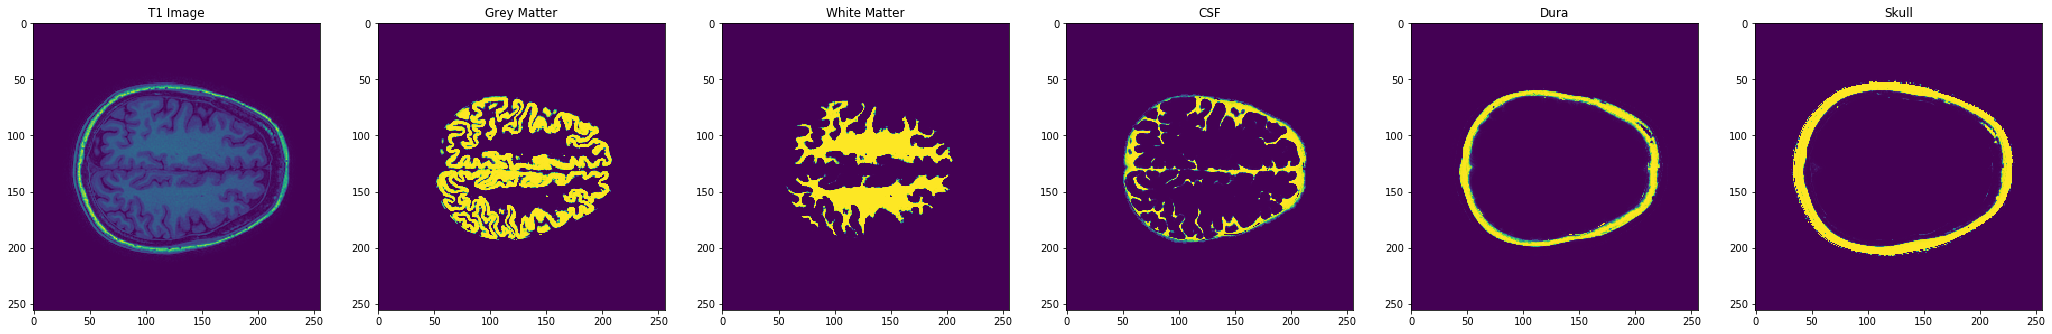

In [212]:
show_images([t1_np, c1_np, c2_np, c3_np, c4_np, c5_np], titles=["T1 Image", "Grey Matter", "White Matter", "CSF", "Dura", "Skull"])

### Extract patches

In [0]:
t1_patches = shuffle(image.extract_patches_2d(t1_np, (23, 23)) / 1390, random_state=0)
c1_patches = shuffle(image.extract_patches_2d(c1_np, (23, 23)), random_state=0)
c2_patches = shuffle(image.extract_patches_2d(c2_np, (23, 23)), random_state=0)
c3_patches = shuffle(image.extract_patches_2d(c3_np, (23, 23)), random_state=0)
c4_patches = shuffle(image.extract_patches_2d(c4_np, (23, 23)), random_state=0)
c5_patches = shuffle(image.extract_patches_2d(c5_np, (23, 23)), random_state=0)

print(t1_patches.shape)
print(c1_patches.shape)
print(c2_patches.shape)
print(c3_patches.shape)
print(c4_patches.shape)
print(c5_patches.shape)

In [235]:
x = t1_patches.reshape((54756, 23, 23, 1))
print(x.shape)

(54756, 23, 23, 1)


In [0]:
c1_patches[]

In [240]:
# Convert c1 patch to thier labels
y = label_patches(len(t1_patches), patches=[c1_patches, c2_patches, c3_patches, c4_patches, c5_patches])
y.shape

(54756, 6)

In [241]:
print(x.shape)
print(y.shape)

(54756, 23, 23, 1)
(54756, 6)


## Stabilize the dataset by dropping alot of the black screens

In [245]:
index_to_drop = black_images[:27000]

new_x = np.delete(x, [index_to_drop], axis=0)
new_y = np.delete(y, [index_to_drop], axis=0)

print(new_x.shape)
print(new_y.shape)

(27756, 23, 23, 1)
(27756, 6)


## Creating the Neural Network

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [0]:
# Define the models architecture
def create_model():
    # Build the architecture
    model = Sequential()
    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', input_shape=(23, 23, 1), padding="same"))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    
    model.add(Dense(6, activation='softmax'))

    # Compile the network
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [307]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 23, 23, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 3872)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                123936    
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 198       
Total params: 124,454
Trainable params: 124,454
Non-trainable params: 0
_________________________________________________________________


In [322]:
model.fit(new_x, new_y, batch_size=128, epochs=10, shuffle=True)

Epoch 1/10
27756/27756 [==============================] - 1s 35us/sample - loss: 0.1456 - acc: 0.9393
Epoch 2/10
27756/27756 [==============================] - 1s 33us/sample - loss: 0.1409 - acc: 0.9413
Epoch 3/10
27756/27756 [==============================] - 1s 32us/sample - loss: 0.1369 - acc: 0.9428
Epoch 4/10
27756/27756 [==============================] - 1s 31us/sample - loss: 0.1341 - acc: 0.9456
Epoch 5/10
27756/27756 [==============================] - 1s 30us/sample - loss: 0.1294 - acc: 0.9468
Epoch 6/10
27756/27756 [==============================] - 1s 30us/sample - loss: 0.1266 - acc: 0.9482
Epoch 7/10
27756/27756 [==============================] - 1s 31us/sample - loss: 0.1240 - acc: 0.9492
Epoch 8/10
27756/27756 [==============================] - 1s 30us/sample - loss: 0.1192 - acc: 0.9515
Epoch 9/10
27756/27756 [==============================] - 1s 30us/sample - loss: 0.1172 - acc: 0.9516
Epoch 10/10
27756/27756 [==============================] - 1s 30us/sample - loss: 

In [0]:
working_models = '/content/drive/My Drive/#6_Brain_Segmentation/WorkingModels/'
model.save('/content/drive/My Drive/#6_Brain_Segmentation/WorkingModels/230_All_25th_Epoch.h5')

## Predict Batch and re-construct the image

In [0]:
from tensorflow.keras.models import load_model

In [0]:
loaded_model = load_model('/content/drive/My Drive/#6_Brain_Segmentation/WorkingModels/230_All_25th_Epoch.h5')

In [0]:
test_patches = image.extract_patches_2d(t1_np, (23, 23)) / 1390
test_patches = test_patches.reshape((54756, 23, 23, 1))

In [0]:
this = np.array(loaded_model.predict_classes(test_patches)).astype(np.float)

In [0]:
done = this.reshape((256-22, 256-22))
done = np.pad(done, (11,11), mode='edge')

## Manual Segmentation vs. AI

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


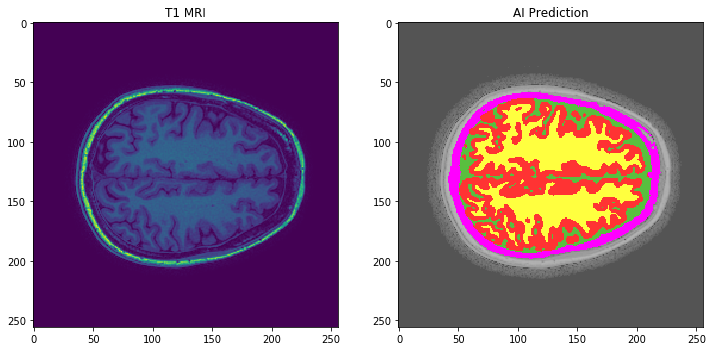

In [341]:
show_images([t1_np, show_segmented(t1_np, done ,show=False)], titles=["T1 MRI", "AI Prediction"])

---
# Helpers

In [0]:
black_images = [] 
greys = []
whites = []
csfs = []
duras = []
skulls = []
def label_patches(num, patches):
    '''
    Always pass in square patches with an odd width and height
    This is needed for use to calculate the center pixel

    :param patches: Patches you would like to label
    :return:
    '''
    labels_list = []
    dim = 12

    for index in range(num):
        # Label as Grey Matter
        if patches[0][index, dim, dim] > 0.50:
            labels_list.append("1")
            greys.append(index)
        # Label as White Matter
        elif patches[1][index, dim, dim] > 0.50:
            labels_list.append("2")
            whites.append(index)
        # Label as CSF
        elif patches[2][index, dim, dim] > 0.50:
            labels_list.append("3")
            csfs.append(index)
        # Label as Dura
        elif patches[3][index, dim, dim] > 0.50:
            labels_list.append("4")
            duras.append(index)
        # Label as Skull
        elif patches[4][index, dim, dim] > 0.50:
            labels_list.append("5")
            skulls.append(index)
        else:
            labels_list.append("0")
            black_images.append(index)
          
    return keras.utils.to_categorical(labels_list, num_classes=6)

In [0]:
def count_ones(y_array):
  ones_here = []
  for i in y_array:
    if i[1] == 1:
      ones_here.append("1")
  print("We have " + str(len(ones_here)) +"ones out of " +str(len(y_array)))

In [0]:
def show_images(images, cols=1, titles=None):
    """
    Display a list of images in a single figure with matplotlib.
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    cols (Default = 1): Number of columns in figure (number of rows is set to np.ceil(n_images/float(cols))).
    titles: List of titles corresponding to each image. Must have the same length as titles.
    """
    assert ((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images / float(cols)), n + 1)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [334]:
print("Black images: " + str(len(black_images)))
print("Grey images: " + str(len(greys)))
print("White images: " + str(len(whites)))
print("Csfs images: " + str(len(csfs)))
print("Duras images: " + str(len(duras)))
print("Skulls images: " + str(len(skulls)))
print("Total = " + str(len(black_images) + len(greys) + len(whites) + len(csfs) + len(duras) + len(skulls)))

Black images: 30814
Grey images: 7976
White images: 5805
Csfs images: 2924
Duras images: 3049
Skulls images: 4188
Total = 54756


In [0]:
def show_segmented(test_img, prediction, show = False):
  # overlay = mark_boundaries(test_back, img_mask)
  gray_img = img_as_float(test_img)

  # adjust gamma of image
  image = adjust_gamma(color.gray2rgb(gray_img), 0.1)
  sliced_image = image.copy()
  
  # Find which index have each label
  grey = np.argwhere(prediction == 1)
  white = np.argwhere(prediction == 2)
  csf = np.argwhere(prediction == 3)
  dura = np.argwhere(prediction == 4)
  skull = np.argwhere(prediction == 4)
  
  red_multiplier = [1, 0.2, 0.2]
  yellow_multiplier = [1,1,0.25]
  green_multiplier = [0.35,0.75,0.25]
  blue_multiplier = [0,0.25,0.9]
  purple_multiplier = [128,0,128]
  
  # Replace Pixels
  for i in grey:
    image[i[0], i[1]] = red_multiplier
  for i in white:
    image[i[0], i[1]] = yellow_multiplier
  for i in csf:
    image[i[0], i[1]] = green_multiplier
  for i in dura:
    image[i[0], i[1]] = blue_multiplier
  for i in skull:
    image[i[0], i[1]] = purple_multiplier
  
  if show:
      io.imshow(image)
      plt.show()

  else:
      return image